In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Các thư viện Scikit-learn (sklearn)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier # Yêu cầu (b)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score # Yêu cầu (c, e)

# Tắt cảnh báo
import warnings
warnings.filterwarnings('ignore')

# --- Tải Dữ liệu ---
file_path = 'maternal_health_risk_data.csv'
df = pd.read_csv(file_path)

print("Tải dữ liệu thành công!")
print(df.head())

# --- Tiền xử lý ---
# 1. Tách X (đặc trưng) và y (mục tiêu)
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# 2. Mã hóa y (Mục tiêu)
# Chuyển ['high risk', 'low risk', 'mid risk'] thành [0, 1, 2]
target_encoder = LabelEncoder()
y_processed = target_encoder.fit_transform(y)
target_names = target_encoder.classes_ # Lưu lại tên gốc

print(f"\nCác đặc trưng (X): {list(X.columns)}")
print(f"Các lớp mục tiêu (Y): {target_names}")

Tải dữ liệu thành công!
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

Các đặc trưng (X): ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
Các lớp mục tiêu (Y): ['high risk' 'low risk' 'mid risk']


--- Câu (a): Biểu đồ Thống kê Số lượng Lớp ---
Thống kê số lượng mỗi lớp:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


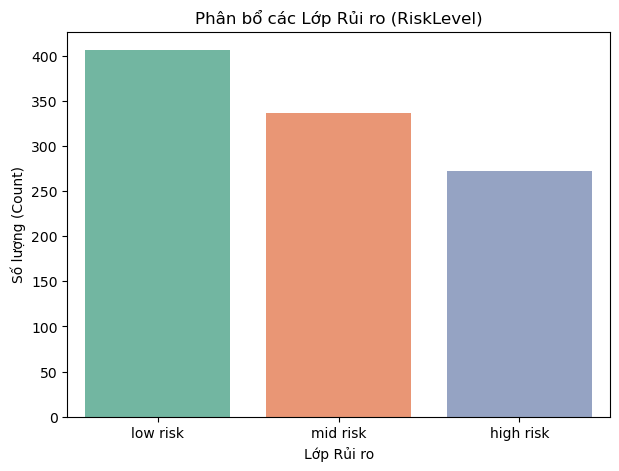

In [3]:
print("--- Câu (a): Biểu đồ Thống kê Số lượng Lớp ---")

# 1. Thống kê số lượng
class_counts = df['RiskLevel'].value_counts()
print("Thống kê số lượng mỗi lớp:")
print(class_counts)

# 2. Vẽ biểu đồ
plt.figure(figsize=(7, 5))
# Dùng countplot của seaborn (dựa trên matplotlib) để vẽ dễ dàng
sns.countplot(x='RiskLevel', data=df, order=class_counts.index, palette='Set2')

plt.title('Phân bổ các Lớp Rủi ro (RiskLevel)')
plt.xlabel('Lớp Rủi ro')
plt.ylabel('Số lượng (Count)')
plt.show()

In [5]:
print("--- Câu (b): Chia dữ liệu, Chuẩn hóa và Huấn luyện KNN (K=5) ---")

# 1. Chia dữ liệu (80% train, 20% test)
# QUAN TRỌNG: Dùng 'stratify=y_processed' vì dữ liệu mất cân bằng
X_train, X_test, y_train, y_test = train_test_split(X, y_processed, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_processed)

# 2. Chuẩn hóa dữ liệu (Scaling)
# BẮT BUỘC cho KNN vì nó dựa trên khoảng cách
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Đã chia (80/20) và chuẩn hóa (scale) dữ liệu.")

# 3. Huấn luyện mô hình KNN (K=5)
k_baseline = 5
model_knn_baseline = KNeighborsClassifier(n_neighbors=k_baseline)
model_knn_baseline.fit(X_train_scaled, y_train)

print(f"Đã huấn luyện xong mô hình KNN (K={k_baseline}).")

--- Câu (b): Chia dữ liệu, Chuẩn hóa và Huấn luyện KNN (K=5) ---
Đã chia (80/20) và chuẩn hóa (scale) dữ liệu.
Đã huấn luyện xong mô hình KNN (K=5).


--- Câu (c): Đánh giá bằng Ma trận Nhầm lẫn ---


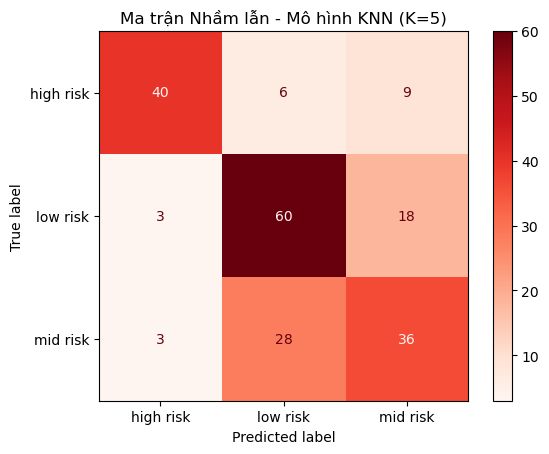

Accuracy cơ sở (K=5): 0.6700 (tức 67.00%)


In [7]:
print("--- Câu (c): Đánh giá bằng Ma trận Nhầm lẫn ---")

# 1. Dự đoán trên tập kiểm thử
y_pred_baseline = model_knn_baseline.predict(X_test_scaled)

# 2. Tính toán và vẽ Ma trận Nhầm lẫn (Confusion Matrix)
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, 
                            display_labels=target_names) # Dùng tên gốc

disp.plot(cmap="Reds")
plt.title(f"Ma trận Nhầm lẫn - Mô hình KNN (K={k_baseline})")
plt.show()

# (Bổ sung) In accuracy cơ sở để so sánh với câu (e)
acc_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy cơ sở (K=5): {acc_baseline:.4f} (tức {acc_baseline*100:.2f}%)")

In [9]:
print("--- Câu (d): Đánh giá Accuracy bằng Cross-Validation (K=5) ---")

# 1. Khởi tạo mô hình KNN (K=5) mới
model_for_cv = KNeighborsClassifier(n_neighbors=k_baseline)

# 2. Chuẩn hóa TOÀN BỘ dữ liệu X (vì cross-val sẽ tự chia)
X_scaled_full = scaler.fit_transform(X)

# 3. Chạy cross_val_score
# cv=5 (theo yêu cầu), scoring='accuracy'
scores = cross_val_score(model_for_cv, X_scaled_full, y_processed, 
                         cv=5, scoring='accuracy')

print(f"Kết quả Accuracy qua 5-fold: {scores}")
print(f"   Accuracy Trung bình: {scores.mean():.4f} (tức {scores.mean()*100:.2f}%)")
print(f"   Độ lệch chuẩn: {scores.std():.4f}")

--- Câu (d): Đánh giá Accuracy bằng Cross-Validation (K=5) ---
Kết quả Accuracy qua 5-fold: [0.80295567 0.63054187 0.66009852 0.69950739 0.7029703 ]
   Accuracy Trung bình: 0.6992 (tức 69.92%)
   Độ lệch chuẩn: 0.0583


In [11]:
print("--- Câu (e): Tối ưu mô hình (Mục tiêu: Accuracy > 80%) ---")
print(f"(Accuracy cơ sở: {acc_baseline:.4f})")

# 1. Định nghĩa không gian tham số (param_grid)
# Chúng ta sẽ thử K, trọng số 'weights' và cách đo 'metric'
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15], # Các giá trị K
    'weights': ['uniform', 'distance'],      # 'uniform': bằng nhau
                                             # 'distance': điểm gần có trọng số cao hơn
    'metric': ['euclidean', 'manhattan']     # Cách đo khoảng cách
}

# 2. Khởi tạo GridSearchCV
# scoring='accuracy'
grid_search = GridSearchCV(KNeighborsClassifier(), 
                           param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           verbose=1)

print("Bắt đầu Grid Search...")
# Chạy Grid Search trên TẬP HUẤN LUYỆN
grid_search.fit(X_train_scaled, y_train)

# 3. In ra kết quả tốt nhất
print("\nGrid Search hoàn tất!")
print(f"Các tham số tốt nhất tìm được: {grid_search.best_params_}")

# 4. Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

# --- Đánh giá lại mô hình TỐT NHẤT trên tập TEST ---
y_pred_best = best_model.predict(X_test_scaled)
acc_best = accuracy_score(y_test, y_pred_best)

print(f"\n--- Đánh giá mô hình TỐT NHẤT ---")
print(classification_report(y_test, y_pred_best, target_names=target_names))
print(f"   Accuracy TỐT NHẤT: {acc_best:.4f} (tức {acc_best*100:.2f}%)")

# 5. Kiểm tra kết quả
if acc_best >= 0.80:
    print(f"\nCHÚC MỪNG! Đã đạt được giá trị kỳ vọng (Accuracy > 80%)")
else:
    print(f"\nCHƯA ĐẠT MỤC TIÊU. (Accuracy = {acc_best*100:.2f}%)")

--- Câu (e): Tối ưu mô hình (Mục tiêu: Accuracy > 80%) ---
(Accuracy cơ sở: 0.6700)
Bắt đầu Grid Search...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Grid Search hoàn tất!
Các tham số tốt nhất tìm được: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}

--- Đánh giá mô hình TỐT NHẤT ---
              precision    recall  f1-score   support

   high risk       0.96      0.93      0.94        55
    low risk       0.87      0.81      0.84        81
    mid risk       0.77      0.85      0.81        67

    accuracy                           0.86       203
   macro avg       0.87      0.86      0.86       203
weighted avg       0.86      0.86      0.86       203

   Accuracy TỐT NHẤT: 0.8571 (tức 85.71%)

CHÚC MỪNG! Đã đạt được giá trị kỳ vọng (Accuracy > 80%)
